### Building Bionomial GLM To predict Emails Open Rates (OR%) , Based on the following Features 
- Time ( month of the year , day of the week )
- Pirority of email , main or reminder 
- Category ( interval , final )
- Constructed Features
 - Length of the subject 
 - Personalization of Email
 - Having emoji or not
 - Casual tone or formal 
 - Urgency at the subject 
 - Metion of price or discount in the subject 
 - Imperative tone in the subject 
 - Mention of product in the subject

In [10]:
#importing libraries 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats



In [11]:
#r reading the data as a dataframe
df = pd.read_csv("Model_Data.csv")
df.columns = df.columns.str.strip()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sent_Date          1279 non-null   object 
 1   Day_of_week        1279 non-null   object 
 2   Category_name      1279 non-null   object 
 3   Main_Vs_REM        1279 non-null   object 
 4   Subject            1279 non-null   object 
 5   Sendings           1279 non-null   int64  
 6   OR                 1279 non-null   float64
 7   Length_Of_subject  1279 non-null   int64  
 8   Personalization    1279 non-null   int64  
 9   Emoji              1279 non-null   int64  
 10  Urgency            1279 non-null   int64  
 11  Tone               1279 non-null   int64  
 12  Price_or_Discount  1279 non-null   int64  
 13  Imperative_Tone    1279 non-null   int64  
 14  Product            1279 non-null   int64  
 15  Month              1279 non-null   int64  
 16  Letter_Count       1279 

In [13]:
columns_to_drop = [ "translation", "CTR clean %","Subject"]  
df = df.drop(columns=columns_to_drop, errors='ignore')
# droping "Subject" is nessesary for generalization during training 

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sent_Date          1279 non-null   object 
 1   Day_of_week        1279 non-null   object 
 2   Category_name      1279 non-null   object 
 3   Main_Vs_REM        1279 non-null   object 
 4   Sendings           1279 non-null   int64  
 5   OR                 1279 non-null   float64
 6   Length_Of_subject  1279 non-null   int64  
 7   Personalization    1279 non-null   int64  
 8   Emoji              1279 non-null   int64  
 9   Urgency            1279 non-null   int64  
 10  Tone               1279 non-null   int64  
 11  Price_or_Discount  1279 non-null   int64  
 12  Imperative_Tone    1279 non-null   int64  
 13  Product            1279 non-null   int64  
 14  Month              1279 non-null   int64  
 15  Letter_Count       1279 non-null   int64  
dtypes: float64(1), int64(11)

In [15]:

# Ensure Sendings are positive integers
if (df['Sendings'] <= 0).any():
    raise ValueError("Some Sendings <= 0. GLM freq_weights must be positive.")

# If OR is >1, assume it's percent and convert to proportion
if df['OR'].max() > 1:
    print("Converting OR from percent to proportion (dividing by 100).")
    df['OR'] = df['OR'] / 100.0

# Quick sanity
assert df['OR'].min() >= 0 and df['OR'].max() <= 1, "OR must be within [0,1] after conversion."


In [16]:
# Create count variables
df['Opens'] = (df['OR'] * df['Sendings']).round().astype(int)
# Ensure Opens are within [0, Sendings]
df['Opens'] = df[['Opens', 'Sendings']].apply(lambda r: min(max(r['Opens'], 0), r['Sendings']), axis=1)
df['Failures'] = df['Sendings'] - df['Opens']

# Quick checks
print("Opens min,max:", df['Opens'].min(), df['Opens'].max())
print("Sendings min,max:", df['Sendings'].min(), df['Sendings'].max())


Opens min,max: 27 19682
Sendings min,max: 186 244401


In [17]:

def get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3):
    """
    Detect outliers in each specified numeric column using Z-score.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to check
    - threshold: Z-score cutoff (default 3)
    
    Returns:
    - Dictionary: column name -> DataFrame of outlier rows
    """
    outlier_dict = {}
    
    for col in columns:
        if col in df.columns:
            col_data = df[col]
            z_scores = np.abs(stats.zscore(col_data.dropna()))
            col_outliers = df.loc[col_data.dropna().index[z_scores > threshold]]
            outlier_dict[col] = col_outliers
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            outlier_dict[col] = pd.DataFrame()  # empty DataFrame if column not found
    
    return outlier_dict





In [18]:
# Set Winsorization thresholds (percentiles)
lower_pct = 0.01  # 1st percentile
upper_pct = 0.99  # 99th percentile

# List of columns to Winsorize
columns_to_winsorize = ['Sendings', 'OR']

for col in columns_to_winsorize:
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    df[col] = np.clip(df[col], lower, upper)  # Cap values at thresholds
    print(f"{col}: capped below {lower:.3f}, capped above {upper:.3f}")



Sendings: capped below 357.000, capped above 241306.620
OR: capped below 0.057, capped above 0.229


In [19]:
# List the columns where you want to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency','Price_or_Discount','Imperative_Tone','Product']
  

# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df["Length_Of_subject"]=df["Length_Of_subject"].replace({1: "long", 0:"short"})
df["Tone"]=df["Tone"].replace({1: "Casual", 0:"Formal"})
month_map = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

# Replace numeric month values with names
df["Month"] = df["Month"].map(month_map)


In [20]:
FEATURES = [
    'Day_of_week', 'Category_name', 'Main_Vs_REM', 'Personalization',
    'Emoji', 'Urgency', 'Tone', 'Price_or_Discount', 'Imperative_Tone',
    'Product', 'Length_Of_subject', 'Month', 'Letter_Count'
]

missing = [f for f in FEATURES if f not in df.columns]
if missing:
    raise KeyError(f"Missing features in df: {missing}")
else:
    print("All features present.")


All features present.


In [21]:
# Define target and features
# -----------------------------
X = df[FEATURES].copy()
y = df[['Opens', 'Failures']]  # binomial target (successes + failures)

# -----------------------------
# Split data
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          
    random_state=42,        
    stratify=None           
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


Training samples: 1023, Test samples: 256


In [22]:
import statsmodels.api as sm
import numpy as np
import pandas as pd


X_train_enc = pd.get_dummies(X_train, drop_first=False)
X_test_enc = pd.get_dummies(X_test, drop_first=False)

# Align columns between train and test
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)


X_train_enc = X_train_enc.astype(float)
X_test_enc  = X_test_enc.astype(float)


y_ratio_train = (y_train['Opens'] / (y_train['Opens'] + y_train['Failures'])).astype(float)
weights_train = (y_train['Opens'] + y_train['Failures']).astype(float)


X_np = sm.add_constant(X_train_enc.values)
y_np = np.asarray(y_ratio_train)
w_np = np.asarray(weights_train)

# Fit model ---
glm_binom = sm.GLM(
    y_np,
    X_np,
    family=sm.families.Binomial(),
    freq_weights=w_np
).fit()

print(glm_binom.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1023
Model:                            GLM   Df Residuals:                 48360922
Model Family:                Binomial   Df Model:                           28
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1589e+07
Date:                Fri, 24 Oct 2025   Deviance:                   2.3198e+05
Time:                        02:03:33   Pearson chi2:                 2.41e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2155      0.001   -212.424      0.0

In [23]:
# Predict OR (probability of open)
pred_OR = glm_binom.predict(sm.add_constant(X_test_enc.values))

# Compare with actuals
results = pd.DataFrame({
    'Actual_OR': y_test['Opens'] / (y_test['Opens'] + y_test['Failures']),
    'Predicted_OR': pred_OR,
    'Sendings': y_test['Opens'] + y_test['Failures']
})

print(results.head())
print("Mean actual OR:", results['Actual_OR'].mean())
print("Mean predicted OR:", results['Predicted_OR'].mean())



      Actual_OR  Predicted_OR  Sendings
1239   0.084407      0.089097     50067
1187   0.078499      0.074088    239724
560    0.131514      0.129855     32202
767    0.138007      0.158583     44679
714    0.112113      0.097592      4656
Mean actual OR: 0.12754428000476503
Mean predicted OR: 0.11089781084388431


In [24]:

mae = mean_absolute_error(results['Actual_OR'], results['Predicted_OR'])
rmse = np.sqrt(mean_squared_error(results['Actual_OR'], results['Predicted_OR']))

print(f"MAE: {mae:.5f}")
print(f"RMSE: {rmse:.5f}")

MAE: 0.02854
RMSE: 0.03798


In [25]:
# construction Calibration Table 
results['decile'] = pd.qcut(results['Predicted_OR'], 10, labels=False)

calibration = results.groupby('decile').apply(
    lambda d: pd.Series({
        'mean_pred': d['Predicted_OR'].mean(),
        'weighted_actual': np.average(d['Actual_OR'], weights=d['Sendings']),
        'count': len(d)
    })
).reset_index()

print("Calibration table (deciles):")
print(calibration)


Calibration table (deciles):
   decile  mean_pred  weighted_actual  count
0       0   0.069291         0.076979   26.0
1       1   0.075160         0.084771   26.0
2       2   0.079701         0.075154   25.0
3       3   0.089448         0.081073   28.0
4       4   0.103726         0.104411   23.0
5       5   0.118904         0.149427   29.0
6       6   0.128118         0.145489   22.0
7       7   0.134815         0.144360   26.0
8       8   0.147250         0.147327   25.0
9       9   0.165312         0.149249   26.0


In [26]:

# Top_Decile Left
overall_avg = np.average(results['Actual_OR'], weights=results['Sendings'])
top_decile = results.nlargest(int(len(results) * 0.1), 'Predicted_OR')
top_avg = np.average(top_decile['Actual_OR'], weights=top_decile['Sendings'])

lift = top_avg / overall_avg
print(f"=== Top-decile lift ===\nOverall avg OR: {overall_avg:.4f}\nTop 10% avg OR: {top_avg:.4f}\nLift: {lift:.2f}×")

=== Top-decile lift ===
Overall avg OR: 0.1153
Top 10% avg OR: 0.1498
Lift: 1.30×


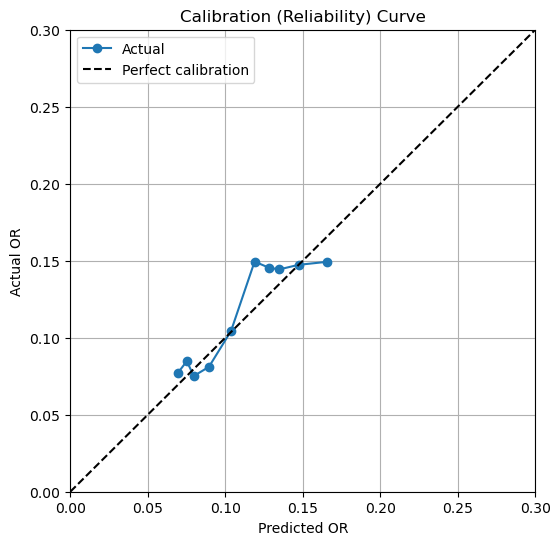

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Sort predictions into 10 bins
results['decile'] = pd.qcut(results['Predicted_OR'], 10, labels=False)

calibration = results.groupby('decile').apply(
    lambda d: pd.Series({
        'mean_pred': d['Predicted_OR'].mean(),
        'weighted_actual': np.average(d['Actual_OR'], weights=d['Sendings'])
    })
).reset_index()

# Plot calibration curve
plt.figure(figsize=(6, 6))
plt.plot(calibration['mean_pred'], calibration['weighted_actual'], marker='o', label='Actual')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
plt.xlabel('Predicted OR')
plt.ylabel('Actual OR')
plt.title('Calibration (Reliability) Curve')
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.legend()
plt.grid(True)
plt.show()



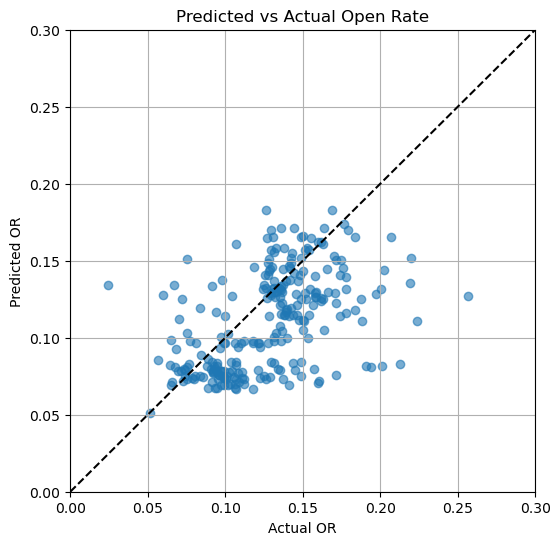

In [28]:
plt.figure(figsize=(6, 6))
plt.scatter(results['Actual_OR'], results['Predicted_OR'], alpha=0.6)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Actual OR')
plt.ylabel('Predicted OR')
plt.title('Predicted vs Actual Open Rate')
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.grid(True)
plt.show()




=== Top 20 GLM Feature Insights ===
                      Feature  Coefficient  Odds_Ratio       Direction
9      Category_name_NL Final    -0.382010    0.682488  ↓ Decreases OR
28    Length_Of_subject_short    -0.373023    0.688649  ↓ Decreases OR
22      Price_or_Discount_yes    -0.339670    0.712005  ↓ Decreases OR
18                Urgency_yes    -0.319244    0.726698  ↓ Decreases OR
11           Main_Vs_REM_MAIN    -0.226150    0.797599  ↓ Decreases OR
24        Imperative_Tone_yes    -0.208945    0.811440  ↓ Decreases OR
2          Day_of_week_Friday    -0.205171    0.814508  ↓ Decreases OR
7         Day_of_week_Tuesday    -0.195318    0.822573  ↓ Decreases OR
14        Personalization_yes    -0.168883    0.844608  ↓ Decreases OR
10  Category_name_NL Interval     0.166521    1.181188  ↑ Increases OR
27     Length_Of_subject_long     0.157534    1.170620  ↑ Increases OR
25                 Product_no    -0.137049    0.871927  ↓ Decreases OR
19                Tone_Casual    -0.1368

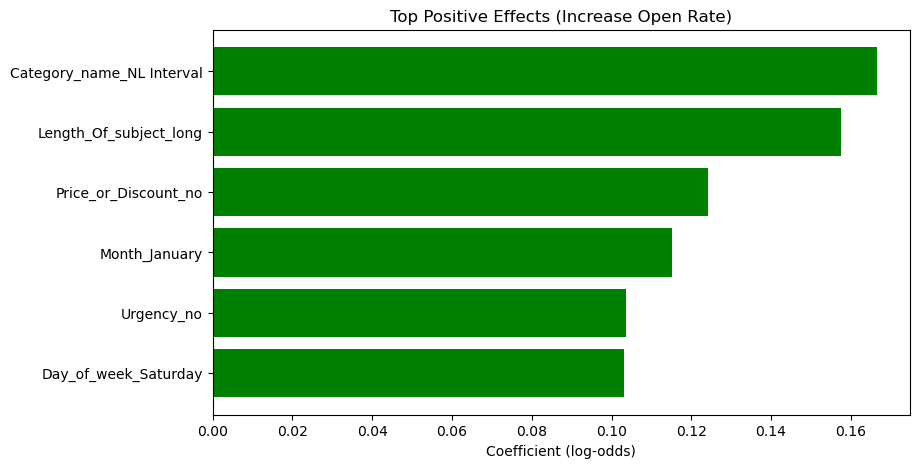

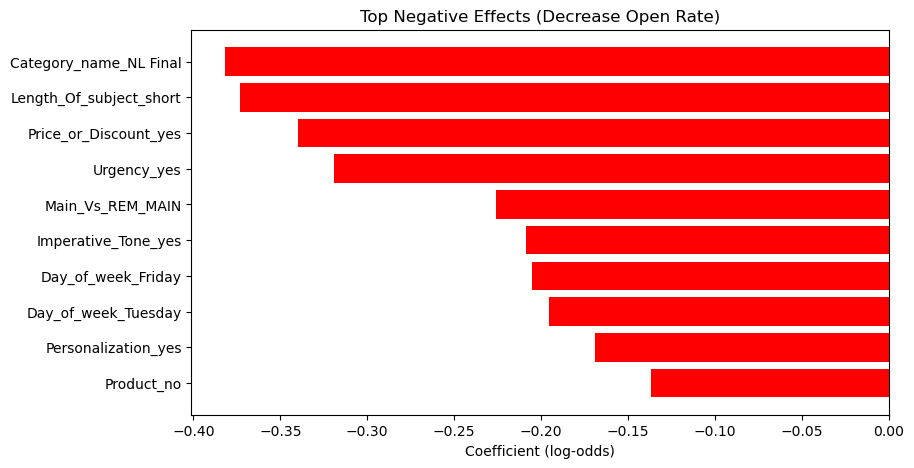

In [29]:

# ----------------------------------------------------------
#Extract GLM Coefficients and Calculate Effect Strength
# ----------------------------------------------------------

def glm_feature_insights(glm_model, X_train_enc, top_n=15):
    """
    Summarize top positive/negative effects from a fitted Binomial GLM.
    """
    coef_df = pd.DataFrame({
        'Feature': ['const'] + list(X_train_enc.columns),
        'Coefficient': glm_model.params
    })
    
    # Drop intercept
    coef_df = coef_df[coef_df['Feature'] != 'const']
    
    # Calculate odds ratios
    coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])
    
    # Interpret direction
    coef_df['Direction'] = np.where(coef_df['Coefficient'] > 0, '↑ Increases OR', '↓ Decreases OR')
    
    # Absolute value for ranking strength
    coef_df['AbsCoef'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values('AbsCoef', ascending=False)
    
    # Show top N
    return coef_df.head(top_n)


# Generate Table


glm_insights = glm_feature_insights(glm_binom, X_train_enc, top_n=20)

print("\n=== Top 20 GLM Feature Insights ===")
print(glm_insights[['Feature', 'Coefficient', 'Odds_Ratio', 'Direction']])



#Visualization (Top Positive vs Negative)


top_pos = glm_insights[glm_insights['Coefficient'] > 0].head(10)
top_neg = glm_insights[glm_insights['Coefficient'] < 0].head(10)

plt.figure(figsize=(9, 5))
plt.barh(top_pos['Feature'], top_pos['Coefficient'], color='green')
plt.title("Top Positive Effects (Increase Open Rate)")
plt.gca().invert_yaxis()
plt.xlabel("Coefficient (log-odds)")
plt.show()

plt.figure(figsize=(9, 5))
plt.barh(top_neg['Feature'], top_neg['Coefficient'], color='red')
plt.title("Top Negative Effects (Decrease Open Rate)")
plt.gca().invert_yaxis()
plt.xlabel("Coefficient (log-odds)")
plt.show()


## Creating Intercative Function For Prediction 

In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# reproducible mapping (same as training) ---
_binary_map = {1: 'yes', 0: 'no'}
_length_map = {1: 'long', 0: 'short'}
_tone_map = {1: 'Casual', 0: 'Formal'}
_month_map = {
    1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
    7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"
}

def predict_open_rate(
    new_data,
    glm_model,
    train_columns,
    sendings_col=None,
    features_to_binary=['Personalization', 'Emoji', 'Urgency', 'Price_or_Discount', 'Imperative_Tone', 'Product'],
    length_col='Length_Of_subject',
    tone_col='Tone',
    month_col='Month'
):
    """
    Predict open rate(s) using a fitted binomial GLM (statsmodels).
    """

    # Normalize input to DataFrame
    if isinstance(new_data, dict):
        df_new = pd.DataFrame([new_data])
    elif isinstance(new_data, pd.Series):
        df_new = pd.DataFrame([new_data.to_dict()])
    else:
        df_new = pd.DataFrame(new_data).copy()

    notes = []

    # Basic checks
    if df_new.shape[0] == 0:
        raise ValueError("new_data is empty")

    # Apply the same mapping as training for binary features (if column exists and values are 1/0)
    for c in features_to_binary:
        if c in df_new.columns:
            df_new[c] = df_new[c].replace(_binary_map)  

    # Length / Tone mapping
    if length_col in df_new.columns:
        df_new[length_col] = df_new[length_col].replace(_length_map)
    if tone_col in df_new.columns:
        df_new[tone_col] = df_new[tone_col].replace(_tone_map)

    # Month mapping (numeric -> name) if numeric
    if month_col in df_new.columns:
        if pd.api.types.is_numeric_dtype(df_new[month_col]):
            df_new[month_col] = df_new[month_col].map(_month_map).fillna(df_new[month_col])

    # Warn about missing expected feature columns (non-fatal)
    missing_features = [c for c in train_columns if c not in df_new.columns and '_' not in c]
    if missing_features:
        notes.append(
            f"Input did not contain some raw feature names ({len(missing_features)} missing). "
            "Unseen columns will be filled with zeros after one-hot encoding."
        )

    # One-hot encode using same strategy as training
    X_new_enc = pd.get_dummies(df_new, drop_first=False)

    # Align the one-hot encoded frame to the training columns (fill missing dummies with 0)
    X_new_aligned = X_new_enc.reindex(columns=train_columns, fill_value=0)

    
    X_new_aligned = X_new_aligned.astype(float)

    # Add constant (statsmodels style) — match training
    X_new_with_const = sm.add_constant(X_new_aligned.values, has_constant='add')

    # Predict
    try:
        preds = glm_model.predict(X_new_with_const)
    except Exception as e:
        raise RuntimeError(f"Prediction failed: {e}")

    # Build result DataFrame
    result = pd.DataFrame({
        'Predicted_OR': np.asarray(preds).astype(float)
    }, index=df_new.index)

    # If sendings present, compute expected opens
    if sendings_col and sendings_col in df_new.columns:
        sendings_vals = pd.to_numeric(df_new[sendings_col], errors='coerce').fillna(0).astype(float)
        result['Input_Sendings'] = sendings_vals.values
        result['Expected_Opens'] = (result['Predicted_OR'] * result['Input_Sendings']).round().astype(int)
    elif 'Sendings' in df_new.columns:
        sendings_vals = pd.to_numeric(df_new['Sendings'], errors='coerce').fillna(0).astype(float)
        result['Input_Sendings'] = sendings_vals.values
        result['Expected_Opens'] = (result['Predicted_OR'] * result['Input_Sendings']).round().astype(int)

    # Attach any notes/warnings
    result['notes'] = "; ".join(notes) if notes else ""

    return result
# Prepare these before calling:
train_columns = X_train_enc.columns.tolist()   # X_train_enc from your training step
# glm_binom is your fitted model from earlier

# Example single-row dict (raw features; include Sendings if you want expected opens)
new_row = {
    'Day_of_week': 'Sunday',
    'Category_name': 'NL Interval',
    'Main_Vs_REM': 'MAIN',
    'Personalization': 1,
    'Emoji': 0,
    'Urgency': 0,
    'Tone': 1,                  # numeric or "Formal"/"Casual"
    'Price_or_Discount': 1,
    'Imperative_Tone': 1,
    'Product': 0,
    'Length_Of_subject': 1,     # numeric or 'long'/'short'
    'Month': 10,
    'Letter_Count': 12,
    'Sendings': 10000
}

out = predict_open_rate(new_row, glm_binom, train_columns, sendings_col='Sendings')
print(out)



   Predicted_OR  Input_Sendings  Expected_Opens notes
0      0.178292         10000.0            1783      


In [ ]:
# Prepare these before calling:
train_columns = X_train_enc.columns.tolist()   # X_train_enc from your training step
# glm_binom is your fitted model from earlier

# Example single-row dict (raw features; include Sendings if you want expected opens)
new_row = {
    'Day_of_week': 'Sunday',
    'Category_name': 'NL Interval',
    'Main_Vs_REM': 'MAIN',
    'Personalization': 1,
    'Emoji': 0,
    'Urgency': 0,
    'Tone': 1,                  # numeric or "Formal"/"Casual"
    'Price_or_Discount': 1,
    'Imperative_Tone': 1,
    'Product': 0,
    'Length_Of_subject': 1,     # numeric or 'long'/'short'
    'Month': 10,
    'Letter_Count': 12,
    'Sendings': 10000
}

out = predict_open_rate(new_row, glm_binom, train_columns, sendings_col='Sendings')
print(out)


   Predicted_OR  Input_Sendings  Expected_Opens notes
0      0.178292         10000.0            1783      


In [36]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def glm_predictor_widget(glm_model, train_columns):
    """
    Interactive widget for predicting open rate using fitted GLM.
    """

    # --- Define available options based on your training schema ---
    day_options = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    category_options = ['NL Interval',"NL Final"]  
    main_rem_options = ['MAIN', 'REM']
    yes_no = ['yes', 'no']
    tone_options = ['Formal', 'Casual']
    length_options = ['short', 'long']
    month_options = [
        'January','February','March','April','May','June',
        'July','August','September','October','November','December'
    ]
    product_options = ['yes', 'no']  # can replace with actual product names if categorical

    # --- Create widgets ---
    w_day = widgets.Dropdown(options=day_options, description='Day:')
    w_cat = widgets.Dropdown(options=category_options, description='Category:')
    w_main = widgets.Dropdown(options=main_rem_options, description='Main vs REM:')
    w_personal = widgets.Dropdown(options=yes_no, description='Personalization:')
    w_emoji = widgets.Dropdown(options=yes_no, description='Emoji:')
    w_urgency = widgets.Dropdown(options=yes_no, description='Urgency:')
    w_tone = widgets.Dropdown(options=tone_options, description='Tone:')
    w_discount = widgets.Dropdown(options=yes_no, description='Price/Discount:')
    w_imperative = widgets.Dropdown(options=yes_no, description='Imperative Tone:')
    w_product = widgets.Dropdown(options=product_options, description='Product:')
    w_length = widgets.Dropdown(options=length_options, description='Subject Length:')
    w_month = widgets.Dropdown(options=month_options, description='Month:')
    w_letter_count = widgets.IntSlider(value=100, min=5, max=60, step=5, description='Letter Count:')
    w_sendings = widgets.IntText(value=10000, description='Sendings:')

    out_box = widgets.Output()

    # --- Prediction callback ---
    def on_predict(change=None):
        with out_box:
            clear_output()

            new_input = {
                'Day_of_week': w_day.value,
                'Category_name': w_cat.value,
                'Main_Vs_REM': w_main.value,
                'Personalization': w_personal.value,
                'Emoji': w_emoji.value,
                'Urgency': w_urgency.value,
                'Tone': w_tone.value,
                'Price_or_Discount': w_discount.value,
                'Imperative_Tone': w_imperative.value,
                'Product': w_product.value,
                'Length_Of_subject': w_length.value,
                'Month': w_month.value,
                'Letter_Count': w_letter_count.value,
                'Sendings': w_sendings.value
            }

            pred = predict_open_rate(new_input, glm_model, train_columns, sendings_col='Sendings')
            open_rate = float(pred['Predicted_OR'].iloc[0]) * 100
            expected_opens = int(pred['Expected_Opens'].iloc[0])
            sendings = int(pred['Input_Sendings'].iloc[0])

            print("=== Prediction Result ===")
            print(f"Predicted Open Rate: {open_rate:.2f}%")
            print(f"Expected Opens: {expected_opens:,} (out of {sendings:,})")

    # --- Predict button ---
    predict_btn = widgets.Button(description='🔮 Predict Open Rate', button_style='success')
    predict_btn.on_click(on_predict)

    # --- Layout ---
    ui = widgets.VBox([
        widgets.HBox([w_day, w_cat, w_main]),
        widgets.HBox([w_personal, w_emoji, w_urgency]),
        widgets.HBox([w_tone, w_discount, w_imperative]),
        widgets.HBox([w_product, w_length, w_month]),
        widgets.HBox([w_letter_count, w_sendings]),
        predict_btn,
        out_box
    ])

    display(ui)

# ✅ Run this line to activate your widget (after glm_binom and train_columns exist)
glm_predictor_widget(glm_binom, train_columns)
